In [1]:
import torch
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os 
import random
import warnings

import torch
import datetime

from loss_utils import *
from models import *

# 전역 변수 선언
SEQ_LENGTH = 7
DROP_ONEHOT = True
SELECTED_COLUMN = "median_pm10" # "median_pm10", "median_no2"

model_name = "Transformer"
mask = False

# featrue 개수 (실제 학습시에는 타겟까지 +1)
if DROP_ONEHOT:
    # INPUT_DIM = 8
    INPUT_DIM = 8 + 6
    # INPUT_DIM = 8 + 339 + 13
# one-hot 포함 개수 (요일정보, 달 정보, city/country정보)
else:
    INPUT_DIM = 8 + 19 + 339 + 13
HIDDEN_DIM = 32
LAYER_DIM = 3
normalization_type = 'mean_std' # 'max', mean_std
col_max = {}
col_mean = {}
col_mean2 = {}
col_std = {}

device = torch.device("cuda")

In [2]:
def get_train_test_data(df):
  # we'll mostly need median and variance values of features for most of our needs

  for col in df.columns:
    for x in ["min", "max", "count", "past_week", "variance"]:
      if x in col:
        df.drop([col], axis=1, inplace=True)

  # df["Population Staying at Home"] = df["Population Staying at Home"].apply(lambda x: x.replace(",", ""))
  # df["Population Not Staying at Home"] = df["Population Not Staying at Home"].apply(lambda x: x.replace(",", ""))

  # Now we want 2 more features. Which day of week it is and which month it is.
  # Both of these will be one-hot and hence we'll add 7+12 = 19 more columns.
  # Getting month id is easy from the datetime column. 
  # For day of week, we'll use datetime library.
  
  df['weekday'] = df['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").weekday())
  df['month'] = df['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").month - 1)

  # using one-hot on Country and City
  Country_onehot = pd.get_dummies(df['Country'])
  # City_onehot = pd.get_dummies(df['City'])
  df.drop('Country', axis=1, inplace=True)
  # df.drop('City', axis=1, inplace=True)
  df = df.join([Country_onehot])
  # df = df.join([Country_onehot, City_onehot])
  
  # using one-hot on month and weekday
  weekday_onehot = pd.get_dummies(df['weekday'])
  weekday_onehot.columns = ["day_"+str(x) for x in weekday_onehot]
  month_onehot = pd.get_dummies(df['month'])
  month_onehot.columns = ["month_"+str(x) for x in month_onehot]
  
  df.drop(['weekday', 'month'], axis=1, inplace=True)
  df = df.join([weekday_onehot, month_onehot])

 

  cities_list = list(set(df['City']))
  cities_list.sort()
  print(cities_list)
  print("total # of cities : ", len(cities_list))
  city_df = {}
  test_indices_of_cities = {}
  train_set = {}
  test_set = {}
  TEST_SET_SIZE = 60                                        

  for city in cities_list:
    city_df[city] = df[df['City'] == city].sort_values('Date').reset_index()
    for col in city_df[city].columns:
      if col in ["median_pm25", "median_o3", "median_so2", "median_no2", "median_pm10", "median_co"]:
        continue
      try:  
        _mean = np.nanmean(city_df[city][col])
        if np.isnan(_mean) == True:
          _mean = 0
        city_df[city][col] = city_df[city][col].fillna(_mean)
      except:
        pass
    if city_df[city].shape[0] < 600 :
      print("City with less than 600 data : {} {}".format(city_df[city].shape[0], city))
      del city_df[city]
      continue
    
    test_index_start = random.randint(0, city_df[city].shape[0] - TEST_SET_SIZE)
    test_indices_of_cities[city] = [test_index_start, test_index_start + TEST_SET_SIZE]

    test_set[city] = city_df[city].iloc[test_index_start:test_index_start + TEST_SET_SIZE]
    train_set[city] = city_df[city].drop(index=list(range(test_index_start, test_index_start + TEST_SET_SIZE)))

  return train_set, test_set

class CityDataForecast(torch.utils.data.Dataset):
  def __init__(self, selected_column, split, train_set, test_set, all_train, all_test):
    self.split = split
    if split == "train":
      self.dataset = train_set
    else:
      self.dataset = test_set

    self.valid_city_idx = 0
    self.valid_day_idx = 1
    self.selected_column = selected_column

  def __getitem__(self, idx):
    # TEST
    if self.split != "train":
      # getting all data out of the validation set
      out, city = self.get_idx_data(idx)
      # print(out.columns)
      
    # TRAIN
    else:
      # getting data randomly for train split
      # Train for only one city
      city = random.choice(cities_list)
      _df = self.dataset[city]
      # arbitrary sequence
      start_idx = random.randint(1,_df.shape[0]-SEQ_LENGTH)
      # -1~6까지(총 seq_length+1만큼)
      out =  _df.iloc[start_idx-1:start_idx+SEQ_LENGTH]

    out = out.drop(['index', 'Date', 'City'], axis=1)

    Y = pd.DataFrame({})
    Y_true = pd.DataFrame({})

    for col in out.columns:
      # target을 Y값으로.
      if col == self.selected_column:
        Y_true[col] = out[col]
        Y[col] = out[col].fillna(col_mean[city][col])
      
      # target을 input features에서 제외.
      if col in ["median_pm25", "median_o3", "median_so2", "median_no2", "median_pm10", "median_co"]:
        out.drop([col], axis=1, inplace=True)
      else:
        out[col] = out[col].astype("float")
      
    out = np.concatenate((np.array(out)[1:,:], np.array(Y)[:-1,:]), axis=1)
    Y = np.array(Y)[1:]
    Y_true = np.array(Y_true)[1:]
    
    return out, Y, Y_true

  def get_idx_data(self, idx):
    city_idx = self.valid_city_idx % len(cities_list)
    city = cities_list[city_idx]
    print(city_idx)
    # city = cities_list[self.valid_city_idx]
    _df = self.dataset[city]

    # -1~seq-1(seq+1길이만큼!)
    out =  _df.iloc[self.valid_day_idx-1:self.valid_day_idx+SEQ_LENGTH]
    # print(out)
    # raise Exception("FINISH")
    
    if self.valid_day_idx+SEQ_LENGTH >= _df.shape[0]-1:
      self.valid_day_idx = 1
      self.valid_city_idx += 1
    else:
      self.valid_day_idx += 1

    return out, city

  def __len__(self):
    if self.split != "train":
      return (60-SEQ_LENGTH)*len(cities_list)
    return len(all_train) - (SEQ_LENGTH - 1)*len(cities_list)


class CityDataEstimatePollutant(torch.utils.data.Dataset):
  def __init__(self, selected_column, split, train_set, test_set, all_train, all_test):
    self.split = split
    if split == "train":
      self.dataset = train_set
    else:
      self.dataset = test_set

    self.valid_day_idx = 0
    self.selected_column = selected_column
    
    self.valid_city_idx = 0

  def __getitem__(self, idx):
    # TEST
    if self.split != "train":
      out, city = self.get_idx_data(idx)
      
    # TRAIN
    else:
      city = random.choice(cities_list)
      _df = self.dataset[city]
      start_idx = random.randint(0,_df.shape[0]-1)
      out = _df.iloc[start_idx:start_idx+1]
      # print(start_idx)

    out = out.drop(['index', 'Date', 'City'], axis=1)

    Y = pd.DataFrame({})
    Y_true = pd.DataFrame({})

    for col in out.columns:
      if col == self.selected_column:
        Y_true[col] = out[col]
        #print(out[col])
        Y[col] = out[col].fillna(col_mean[city][col])
      
      if col in ["median_pm25", "median_o3", "median_so2", "median_no2", "median_pm10", "median_co"]:
        out.drop([col], axis=1, inplace=True)
      else:
        out[col] = out[col].astype("float")

    out = np.array(out)
    Y = np.array(Y)
    Y_true = np.array(Y_true)
    
    # print(Y_true)
    return out, Y, Y_true

  def get_idx_data(self, idx):
    city = cities_list[self.valid_city_idx]
    _df = self.dataset[city]

    out =  _df.iloc[self.valid_day_idx:self.valid_day_idx+1]
    
    # _df.shape[0]-1
    if self.valid_day_idx >= _df.shape[0]-1:
      self.valid_day_idx = 0
      self.valid_city_idx += 1
    else:
      self.valid_day_idx += 1

    # print(self.valid_day_idx)
    return out, city

  def __len__(self):
    if self.split != "train":
      return 60*len(cities_list)
    return len(all_train)

In [3]:
import lime
from lime.lime_tabular import LimeTabularExplainer

# from AirPollution_integ_ours import *


# 데이터 로드
dfs = []
# dfs.append(pd.read_csv("./data/US2019to2023.csv"))
# dfs.append(pd.read_csv("./data/CA2019to2023.csv"))
dfs.append(pd.read_csv("./data/CN2019to2023.csv"))
# dfs.append(pd.read_csv("./data/DE2019to2023.csv"))
# dfs.append(pd.read_csv("./data/ES2019to2023.csv"))
# dfs.append(pd.read_csv("./data/FR2019to2023.csv"))
# dfs.append(pd.read_csv("./data/GB2019to2023.csv"))
dfs.append(pd.read_csv("./data/IN2019to2023.csv"))
dfs.append(pd.read_csv("./data/IR2019to2023.csv"))
dfs.append(pd.read_csv("./data/JP2019to2023.csv"))
dfs.append(pd.read_csv("./data/KR2019to2023.csv"))
# dfs.append(pd.read_csv("./data/RO2019to2023.csv"))
dfs.append(pd.read_csv("./data/TR2019to2023.csv"))

df = pd.concat(dfs, ignore_index=True)
df.to_csv("./data/asia2019to2023.csv")
# df = pd.read_csv("./data/integ2019to2023.csv")
# df.drop('Unnamed: 0', axis=1, inplace=True)

# Data Preprocessing
train_set, test_set = get_train_test_data(df)
print("Finish Datza Preprocessing")

cities_list = list(train_set.keys())


# print("train data")
all_train = pd.DataFrame()
for city in cities_list:
    all_train = all_train.append(train_set[city], ignore_index=True)

# print("test data")
all_test = pd.DataFrame({})
for city in test_set:
    all_test = all_test.append(test_set[city], ignore_index=True)

# print("concat data")
concat_df = pd.concat([all_train,all_test],axis=0)

# print("city")
# i=1
for city in cities_list:
    col_mean[city] = {}
    for col in train_set[city]:
        if col in ["index", "Date", "City", "Country"]:
            continue

        train_set[city][col] = train_set[city][col].astype("float")
        test_set[city][col] = test_set[city][col].astype("float")

        if col in ["median_pm25", "median_o3", "median_so2", "median_no2", "median_pm10", "median_co"]:
            _mean = np.nanmean(train_set[city][col])
            if np.isnan(_mean) == True:
                _mean = 0
        
            col_mean[city][col] = _mean
            train_set[city][col] = train_set[city][col].fillna(_mean)

        if normalization_type == 'mean_std':
            col_mean2[col] = np.nanmean(concat_df[col].astype("float"))
            col_std[col] = np.nanstd(concat_df[col].astype("float"))
            train_set[city][col] = (train_set[city][col] - col_mean2[col]) / (col_std[col] + 0.001)
            test_set[city][col] = (test_set[city][col] - col_mean2[col]) / (col_std[col] + 0.001)

        else:
            col_max[col] = concat_df[col].astype("float").max()
            train_set[city][col] = train_set[city][col] / (col_max[col] + 0.001)
            test_set[city][col] = test_set[city][col] / (col_max[col] + 0.001)

#     # print("drop onehot or not", i)
#     # i += 1
#     if DROP_ONEHOT:
#         # print(len(train_set[city].columns.to_list()))
#         train_set[city].drop(train_set[city].columns[-(19):], axis=1, inplace=True)
#         test_set[city].drop(test_set[city].columns[-(19):], axis=1, inplace=True)
#         # train_set[city].drop(train_set[city].columns[-(19 + 339 + 13):], axis=1, inplace=True)
#         # test_set[city].drop(test_set[city].columns[-(19 + 339 + 13):], axis=1, inplace=True)
#         # print(len(train_set[city].columns.to_list()))

# # number of data per city
# print("num of cities : ", len(cities_list))
# for city in cities_list:
#     print(city+"({})".format(len(train_set[city])), end=", ")
    
# print(len(train_set[city].columns.to_list()))
# print(train_set[city].columns.to_list())
# print(train_set[city].columns)
    
# # Fix Seed for DataLoader
# g = torch.Generator()
# g.manual_seed(0)


# train_data = CityDataEstimatePollutant(SELECTED_COLUMN, "train", train_set, test_set, all_train, all_test)
# val_data = CityDataEstimatePollutant(SELECTED_COLUMN, "test", train_set, test_set, all_train, all_test)

# x_train = []
# y_train = []
# for idx in range(len(train_data)):
#     data, target, _ = train_data[idx]
#     x_train.append(data)
#     y_train.append(target)
# x_train = np.array(x_train)
# y_train = np.array(y_train)

# x_test = []
# y_test = []
# for idx in range(len(val_data)):
#     data, target, _ = val_data[idx]
#     x_test.append(data)
#     y_test.append(target)
# x_test = np.array(x_test)
# y_test = np.array(y_test)

['Adana', 'Adapazarı', 'Akita', 'Andong', 'Ankara', 'Antakya', 'Anyang', 'Arāk', 'Balıkesir', 'Bandar Abbas', 'Beijing', 'Bengaluru', 'Bhopal', 'Bursa', 'Busan', 'Chandigarh', 'Changchun', 'Changsha', 'Changwon', 'Changzhou', 'Chengdu', 'Chennai', 'Cheongju-si', 'Chiba', 'Chongqing', 'Chuncheon', 'Daegu', 'Daejeon', 'Delhi', 'Denizli', 'Dongguan', 'Erzurum', 'Eskişehir', 'Foshan', 'Fukuoka', 'Fushun', 'Fuzhou', 'Gandhinagar', 'Ghāziābād', 'Gifu-shi', 'Guangzhou', 'Guiyang', 'Gwangju', 'Haikou', 'Hangzhou', 'Harbin', 'Hefei', 'Hegang', 'Hiroshima', 'Hohhot', 'Hyderabad', 'Hāpur', 'Incheon', 'Isfahan', 'Istanbul', 'Jaipur', 'Jeju City', 'Jeonju', 'Jieyang', 'Jinan', 'Kagoshima', 'Kanazawa', 'Karaj', 'Kayseri', 'Kerman', 'Kermanshah', 'Khorramabad', 'Khorramshahr', 'Kobe', 'Kochi', 'Kolkata', 'Konya', 'Kumamoto', 'Kunming', 'Kyoto', 'Kütahya', 'Lanzhou', 'Lhasa', 'Lucknow', 'Mashhad', 'Matsuyama', 'Miyazaki', 'Mokpo', 'Mumbai', 'Muzaffarnagar', 'Mysore', 'Nagano', 'Nagasaki', 'Nagoya', 'N

/tmp/ipykernel_4091506/2397376877.py:55: RuntimeWarning: Mean of empty slice
  _mean = np.nanmean(city_df[city][col])
/tmp/ipykernel_4091506/2397376877.py:55: RuntimeWarning: Mean of empty slice
  _mean = np.nanmean(city_df[city][col])
/tmp/ipykernel_4091506/2397376877.py:55: RuntimeWarning: Mean of empty slice
  _mean = np.nanmean(city_df[city][col])
/tmp/ipykernel_4091506/2397376877.py:55: RuntimeWarning: Mean of empty slice
  _mean = np.nanmean(city_df[city][col])
/tmp/ipykernel_4091506/2397376877.py:55: RuntimeWarning: Mean of empty slice
  _mean = np.nanmean(city_df[city][col])
/tmp/ipykernel_4091506/2397376877.py:55: RuntimeWarning: Mean of empty slice
  _mean = np.nanmean(city_df[city][col])
/tmp/ipykernel_4091506/2397376877.py:55: RuntimeWarning: Mean of empty slice
  _mean = np.nanmean(city_df[city][col])
/tmp/ipykernel_4091506/2397376877.py:55: RuntimeWarning: Mean of empty slice
  _mean = np.nanmean(city_df[city][col])
/tmp/ipykernel_4091506/2397376877.py:55: RuntimeWarning:

Finish Datza Preprocessing


/tmp/ipykernel_4091506/557648567.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_train = all_train.append(train_set[city], ignore_index=True)
/tmp/ipykernel_4091506/557648567.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_test = all_test.append(test_set[city], ignore_index=True)
/tmp/ipykernel_4091506/557648567.py:60: RuntimeWarning: Mean of empty slice
  _mean = np.nanmean(train_set[city][col])


In [4]:
def create_look_ahead_mask(size, device):
    mask = torch.ones((size, size), device=device)
    mask = torch.triu(mask, diagonal=1)
    return mask  # (size, size)


In [5]:
import pickle
# with open('x_train_'+SELECTED_COLUMN+'.pkl', 'wb') as f:
#     pickle.dump(x_train, f)
    
# with open('y_train_'+SELECTED_COLUMN+'.pkl', 'wb') as f:
#     pickle.dump(y_train, f)

# with open('x_test_'+SELECTED_COLUMN+'.pkl', 'wb') as f:
#     pickle.dump(x_test, f)

# with open('y_test_'+SELECTED_COLUMN+'.pkl', 'wb') as f:
#     pickle.dump(y_test, f)
    
    
with open('x_train_'+SELECTED_COLUMN+'.pkl', 'rb') as f:
    x_train = pickle.load(f)
    
with open('y_train_'+SELECTED_COLUMN+'.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('x_test_'+SELECTED_COLUMN+'.pkl', 'rb') as f:
    x_test = pickle.load(f)

with open('y_test_'+SELECTED_COLUMN+'.pkl', 'rb') as f:
    y_test = pickle.load(f)
    
    

In [6]:
x_train = [item for sublist in x_train for item in sublist]
y_train = [item for sublist in y_train for item in sublist]
x_test = [item for sublist in x_test for item in sublist]
y_test = [item for sublist in y_test for item in sublist]

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))
print(x_test)

258270
258270
9780
9780
[[ 0.55436091 -1.02791602  0.49989177 ... -0.49527413 -0.37639822
   2.86065359]
 [ 0.44022039 -1.02791602  0.54633358 ... -0.49527413 -0.37639822
   2.86065359]
 [-0.29027888 -1.02791602  0.40700815 ... -0.49527413 -0.37639822
   2.86065359]
 ...
 [ 1.50857558 -1.01018249  1.38228612 ...  2.0089839  -0.37639822
  -0.34733123]
 [ 1.48118186 -1.02200485  1.26153742 ...  2.0089839  -0.37639822
  -0.34733123]
 [ 0.87851996 -1.02496043  1.22438397 ...  2.0089839  -0.37639822
  -0.34733123]]


In [7]:
from lime import lime_tabular

In [8]:
sequences_train = []

print(x_train[1])
print(y_train[0])
# 반복문을 사용하여 시퀀스를 순회하면서 조작 수행
for i in range(1, len(x_train)):
    seq = x_train[i]
    prev_pollution = y_train[i-1]
    
    # feature1과 airpollution level 0를 결합하여 시퀀스 생성
    combined_seq = np.concatenate((seq, prev_pollution), axis=0)
    
    # 생성된 시퀀스를 리스트에 추가
    sequences_train.append(combined_seq)
sequences_train = np.array(sequences_train)


[ 0.18911127  0.93653151  1.27082578  1.29247947 -1.74400051 -0.35805261
  0.19917061 -0.09088619 -0.69095992 -0.40073853 -0.34333554  2.0089839
 -0.37639822 -0.34733123]
[-0.01159008]


In [9]:
sequences_test = []

print(x_test[1])
print(y_test[0])
# 반복문을 사용하여 시퀀스를 순회하면서 조작 수행
for i in range(1, len(x_test)):
    seq = x_test[i]
    prev_pollution = y_test[i-1]
    
    # feature1과 airpollution level 0를 결합하여 시퀀스 생성
    combined_seq = np.concatenate((seq, prev_pollution), axis=0)
    
    # 생성된 시퀀스를 리스트에 추가
    sequences_test.append(combined_seq)
sequences_test = np.array(sequences_test)


[ 0.44022039 -1.02791602  0.54633358  0.3486131   0.58934756 -0.35805261
  0.26715196 -0.09088619 -0.69095992 -0.40073853 -0.34333554 -0.49527413
 -0.37639822  2.86065359]
[-0.63193002]


In [10]:
num_samples = len(sequences_train - SEQ_LENGTH + 1)
print(sequences_train.shape[1])
x_train_seq = np.zeros((num_samples,105))
y_train_seq = np.zeros((num_samples,1))

i=0
while (i+SEQ_LENGTH-1) < len(x_train_seq):
    # print(sequences_train[i:i+SEQ_LENGTH].shape)
    # print(x_train_seq[i].shape)
    x_train_seq[i] = np.concatenate(sequences_train[i:i+SEQ_LENGTH], axis=0)
    # print(x_train_seq[i])
    y_train_seq[i] = y_train[i+SEQ_LENGTH-1]
    i+=1

print(x_train_seq.shape)
print(y_train_seq.shape)

15
(258269, 105)
(258269, 1)


In [11]:
num_samples = len(sequences_test - SEQ_LENGTH + 1)
print(sequences_test.shape[1])
x_test_seq = np.zeros((num_samples,105))
y_test_seq = np.zeros((num_samples,1))

i=0
while (i+SEQ_LENGTH-1) < len(x_test_seq):
    # print(sequences_test[i:i+SEQ_LENGTH].shape)
    # print(x_test_seq[i].shape)
    x_test_seq[i] = np.concatenate(sequences_test[i:i+SEQ_LENGTH], axis=0)
    # print(x_test_seq[i])
    y_test_seq[i] = y_test[i+SEQ_LENGTH-1]
    i+=1

print(x_test_seq.shape)
print(y_test_seq.shape)

15
(9779, 105)
(9779, 1)


In [23]:
features = ['median_humidity','median_precipitation', 'median_dew', 'median_temperature','median_wind_gust',
              'median_wd', 'median_pressure', 'median_wind_speed', 'CN', 'IN', 'IR', 'JP', 'KR', 'TR', SELECTED_COLUMN]
feature_names = []
for i in range(0,7):
    for j in range(0,14):
        feature_names.append(str(i+1) + 'th sequence ' + features[j])
    feature_names.append(str(i) + 'th sequence ' + features[-1])
print(feature_names)
print(len(feature_names))


# 1. LIME 인스턴스 생성
explainer = lime_tabular.LimeTabularExplainer(x_train_seq, mode="regression", feature_names=feature_names)

['1th sequence median_humidity', '1th sequence median_precipitation', '1th sequence median_dew', '1th sequence median_temperature', '1th sequence median_wind_gust', '1th sequence median_wd', '1th sequence median_pressure', '1th sequence median_wind_speed', '1th sequence CN', '1th sequence IN', '1th sequence IR', '1th sequence JP', '1th sequence KR', '1th sequence TR', '0th sequence median_pm10', '2th sequence median_humidity', '2th sequence median_precipitation', '2th sequence median_dew', '2th sequence median_temperature', '2th sequence median_wind_gust', '2th sequence median_wd', '2th sequence median_pressure', '2th sequence median_wind_speed', '2th sequence CN', '2th sequence IN', '2th sequence IR', '2th sequence JP', '2th sequence KR', '2th sequence TR', '1th sequence median_pm10', '3th sequence median_humidity', '3th sequence median_precipitation', '3th sequence median_dew', '3th sequence median_temperature', '3th sequence median_wind_gust', '3th sequence median_wd', '3th sequence

In [24]:
# 2. 입력 데이터 준비
input_data = x_test_seq



In [25]:



if model_name == 'RNN':
    mask = False
    model = RNN(1, INPUT_DIM+1, HIDDEN_DIM, LAYER_DIM).to(device)
elif model_name == 'LSTM':
    mask = False
    model = LSTM(1, INPUT_DIM+1, HIDDEN_DIM, LAYER_DIM).to(device)
elif model_name == 'Transformer':
    mask = True
    model = Transformer(num_layers=6, D=16, H=10, hidden_mlp_dim=32, inp_features=INPUT_DIM+1, out_features=1, dropout_rate=0.1, attention_type='regular', SL=SEQ_LENGTH).to(device) # cosine_square, cosine, regular # 6L, 12H
elif model_name == 'CosSquareFormer':
    mask = True
    model = Transformer(num_layers=6, D=16, H=10, hidden_mlp_dim=32, inp_features=INPUT_DIM+1, out_features=1, dropout_rate=0.1, attention_type='cosine_square', SL=SEQ_LENGTH).to(device) # cosine_square, cosine, regular # 6L, 12H
else:
    raise Exception("model name is strange")

model.load_state_dict(torch.load('save_KCC_ours/'+SELECTED_COLUMN+'/'+model_name+'_'+str(SEQ_LENGTH)+'.pth'))

def predict_fn(input_data):
    input_data = input_data.reshape(1,-1)
    # (1, 7, 15) 모양의 빈 배열 생성
    reshaped_array = np.empty((1, 7, 15))

    # 원래 배열의 요소를 순서대로 가져와서 새로운 모양으로 배열 채우기
    for i in range(7):
        for j in range(15):
            reshaped_array[0, i, j] = input_data[0, i*15 + j]
    
    input_tensor = torch.tensor(reshaped_array)  # 입력 데이터를 텐서로 변환
    input_tensor = input_tensor.to(torch.float32)
    with torch.no_grad():
        model.eval()  # 모델을 평가 모드로 설정
        # print(input_tensor.shape)
        if mask:
            masking = create_look_ahead_mask(input_tensor.shape[1], device)
            # input_tensor = torch.unsqueeze(input_tensor, 0)
            # print(input_tensor.shape)
            output, _ = model(input_tensor.to(device), masking)
        else:
            output = model(input_tensor.to(device))  # 모델에 입력 데이터 전달하여 예측 수행
    output = output[:,-1,:]
    # num_samples를 고려하여 결과를 반환
    if num is not None:
        return np.repeat(output.cpu().detach().numpy(), num)
    else:
        return output.cpu().detach().numpy()

In [89]:
# idx = random.randint(1, len(x_test_seq))
idx = 1300
print(idx)

print(x_test_seq[idx][:15])
# print(x_test_seq[idx][15:30])
# print(x_test_seq[idx][30:45])
# print(x_test_seq[idx][45:60])
# print(x_test_seq[idx][60:75])
# print(x_test_seq[idx][75:90])
# print(x_test_seq[idx][90:105])
print(col_std)
humidity = x_test_seq[idx][15:30][0]*col_std['median_humidity'] + col_mean2['median_humidity']
temperature = x_test_seq[idx][60:75][0]*col_std['median_temperature'] + col_mean2['median_temperature']
wind_speed = x_test_seq[idx][30:45][0]*col_std['median_wind_speed'] + col_mean2['median_wind_speed']
pressure = x_test_seq[idx][90:105][0]*col_std['median_pressure'] + col_mean2['median_pressure']
wind_gust = x_test_seq[idx][45:60][0]*col_std['median_wind_gust'] + col_mean2['median_wind_gust']
dew = x_test_seq[idx][90:105][0]*col_std['median_dew'] + col_mean2['median_dew']
wd = x_test_seq[idx][75:90][0]*col_std['median_wd'] + col_mean2['median_wd']
precipitation = x_test_seq[idx][:15][0]*col_std['median_precipitation'] + col_mean2['median_precipitation']

print("humidity:",humidity)
print("temperature:",temperature)
print("wind_speed:",wind_speed)
print("pressure:",pressure)
print("wind_gust:",wind_gust)
print("dew:",dew)
print("wd:",wd)
print("precipitation:",precipitation)

# 'median_humidity','median_precipitation', 'median_dew', 'median_temperature','median_wind_gust',
#               'median_wd', 'median_pressure', 'median_wind_speed', 'CN', 'IN', 'IR', 'JP', 'KR', 'TR',
# '7th sequence CN', '7th sequence IN', '7th sequence IR', '7th sequence JP', '7th sequence KR', '7th sequence TR'
num=100
print("Prediction : ", predict_fn(x_test_seq[idx])[0]* col_std[SELECTED_COLUMN] + col_mean2[SELECTED_COLUMN])
print("Actual :     ", y_test_seq[idx]* col_std[SELECTED_COLUMN] + col_mean2[SELECTED_COLUMN])
# 3. LIME 설명 생성
explanation = explainer.explain_instance(x_test_seq[idx], predict_fn, num_features=(INPUT_DIM+1)*7, num_samples=num)
print(explanation)
# # 4. 결과 출력
# explanation.show_in_notebook()

1300
[ 0.33977674 -1.02791602  1.15007708  0.93244797 -0.02938009 -0.35805261
  0.21600409 -0.09088619 -0.69095992  2.48103111 -0.34333554 -0.49527413
 -0.37639822 -0.34733123 -0.06798462]
{'median_humidity': 21.90182812983846, 'median_no2': 10.31566658569092, 'median_precipitation': 33.833203382435165, 'median_co': 7.683791534333296, 'median_dew': 10.765161401442661, 'median_temperature': 10.275878530778463, 'median_pm25': 45.812343285349804, 'median_wind_gust': 4.314824013401973, 'median_pm10': 35.463426238324786, 'median_o3': 13.450368988941495, 'median_wd': 71.39308123201408, 'median_pressure': 154.45310943063186, 'median_so2': 8.40831341101894, 'median_wind_speed': 3.574199007981097, 'CN': 0.46803057686502575, 'IN': 0.346008999201403, 'IR': 0.3079173427143449, 'JP': 0.3983198736505196, 'KR': 0.3304384547508407, 'TR': 0.31072217351906123, 'day_0': 0.35008369196676026, 'day_1': 0.3498933786825138, 'day_2': 0.3500874961634271, 'day_3': 0.349961914840963, 'day_4': 0.349965721633974, '

Text(0.5, 1.0, 'Local explanation')

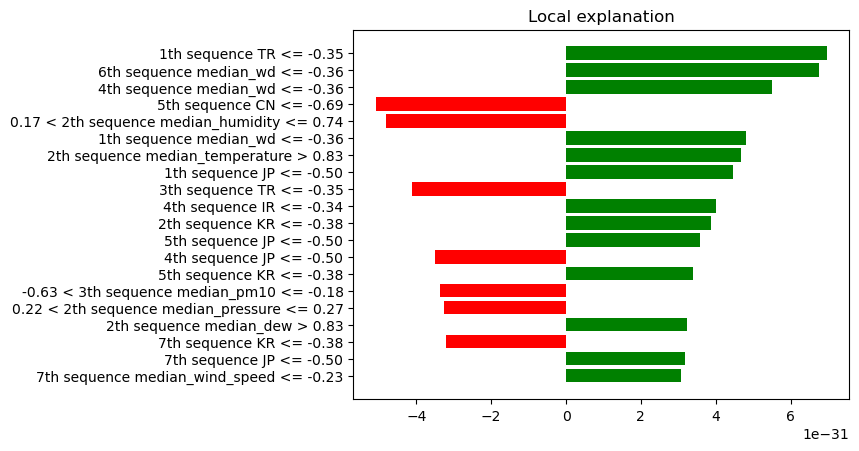

In [85]:
import matplotlib.pyplot as plt
label=1
exp = explanation.as_list(label=label)
# exp = explanation.as_list(label=label)
exp_sorted = sorted(exp, key=lambda x: abs(x[1]), reverse=True)[:20]
fig = plt.figure()
vals = [x[1] for x in exp_sorted]
names = [x[0] for x in exp_sorted]
vals.reverse()
names.reverse()
colors = ['green' if x > 0 else 'red' for x in vals]
pos = np.arange(len(exp_sorted)) + .5
plt.barh(pos, vals, align='center', color=colors)
plt.yticks(pos, names)
if explanation.mode == "classification":
    title = 'Local explanation for class %s' % explanation.class_names[label]
else:
    title = 'Local explanation'
plt.title(title)